# Classifying Diaster Related Tweets as Real or Fake
In this project, i will be working as a data scientist for a new analytical company interested in monitoring and analyzing news on social media platforms.

One of the most popular platform is Twitter now X, which has become an important communication in terms of emergency.

The company has given us a project in which they want us to build a deep learning text classification model that predicts which tweets are about real disaster and which are not.

In [2]:
# Libaries

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, TextVectorization, LSTM, Bidirectional, GlobalAveragePooling1D, Dropout
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('train.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
train_df.shape

(7613, 5)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_df.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [7]:
for i in train_df.columns:
  print(F"{i}: {train_df[i].nunique()}")

id: 7613
keyword: 221
location: 3341
text: 7503
target: 2


The training dataset has 7513 observations and 5 features. Out of the features the `keyword` and `location` have missing values.

Each values in the `id` features are sets of unique numbers. The `id`,`location` and `keyword` have no contribution in predicting our outcomes(`target`). Therefore the 3 aforementioned featurs will be dropped.

## Data Exploration

In [8]:
# dropping the variables that are not useful for our modeling

train_df.drop(['id', 'location', 'keyword'], axis=1, inplace=True)
train_df.head(2)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1


In [9]:
# Percentage of the target variable

train_df['target'].value_counts(normalize = True) * 100

,proportion
target,
0,57.034021
1,42.965979


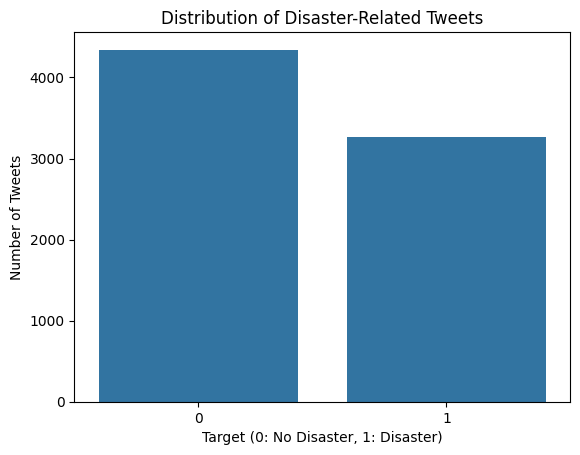

In [10]:
# Distribution of target variables

sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster-Related Tweets')
plt.xlabel('Target (0: No Disaster, 1: Disaster)')
plt.ylabel('Number of Tweets')
plt.show()

Using the distribution of the `target` variables, it shows that an average tweet indicates there are no diasters.



## Text Processing

Preprocessing text data is important for several reasons. It is a necessary steps in any natural language processing (NLP) task, as it helps to clean and standadize the text, making it easier for NLP algorithm to process.

In [11]:
# change the text variable format to a lower case
train_df['text'] = train_df['text'].str.lower()

In [12]:
# create a function to remove the punctuation marks
import re

def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', ' ', text)
  return text

train_df['text'] = train_df['text'].apply(remove_punctuation)

In [13]:
# create a function to tokenize the text into individuals words
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def tokenization(text):
  return word_tokenize(text)

train_df['text_tokenized'] = train_df['text'].apply(tokenization)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
# remove stopwords from tokenized_text

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.remove('not')

def remove_stopwords(text):
  return [word for word in text if word not in stop_words]

train_df['text_stop'] = train_df['text_tokenized'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# lemmatize the words in text_tokenized

from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
  return [lemmatizer.lemmatize(word = word, pos='v') for word in text]

train_df['text_lemmatized'] = train_df['text_stop'].apply(lemmatize_words)

# join the lemmatize token
train_df['final_text'] = train_df['text_lemmatized'].str.join(' ')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
train_df.head()

,text,target,text_tokenized,text_stop,text_lemmatized,final_text
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic...",residents ask shelter place notify officer eva...
3,13 000 people receive wildfires evacuation or...,1,"[13, 000, people, receive, wildfires, evacuati...","[13, 000, people, receive, wildfires, evacuati...","[13, 000, people, receive, wildfires, evacuati...",13 000 people receive wildfires evacuation ord...
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfires pou...


Series of text preprocessing were performed on the `text` variable.
+ Convert to lower case
+ remove punctuation marks
+ using NLTK (natural language toolskit): tokenization, stop words removal and lemmatization of tokens.

Preprocessing of text data can improve the accuracy of our model.

## Visualization with WorldCloud

In [17]:
train_df_disaster = train_df[train_df['target'] == 1]

train_df_not_disaster = train_df[train_df['target'] == 0]

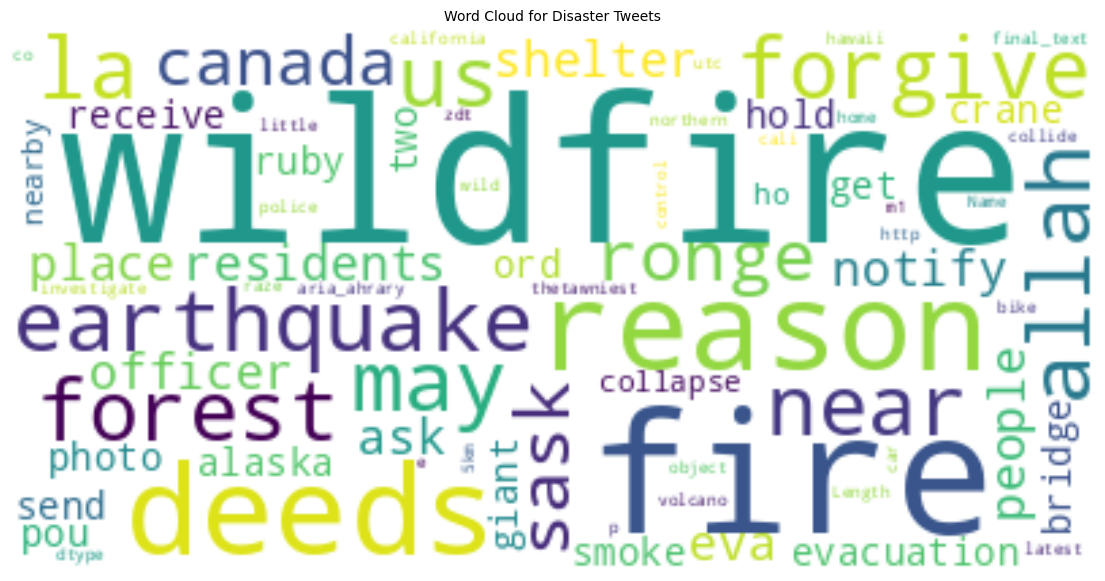

In [18]:
from wordcloud import WordCloud

word_cloud_disaster = WordCloud(max_words = 500, stopwords = stop_words,background_color='white',collocations = True,
                                random_state=100).generate(str((train_df_disaster['final_text'])))

plt.figure(figsize=(14, 10))
plt.imshow(word_cloud_disaster, interpolation='bilinear')
plt.title('Word Cloud for Disaster Tweets', fontsize = 10)
plt.axis('off')
plt.show()

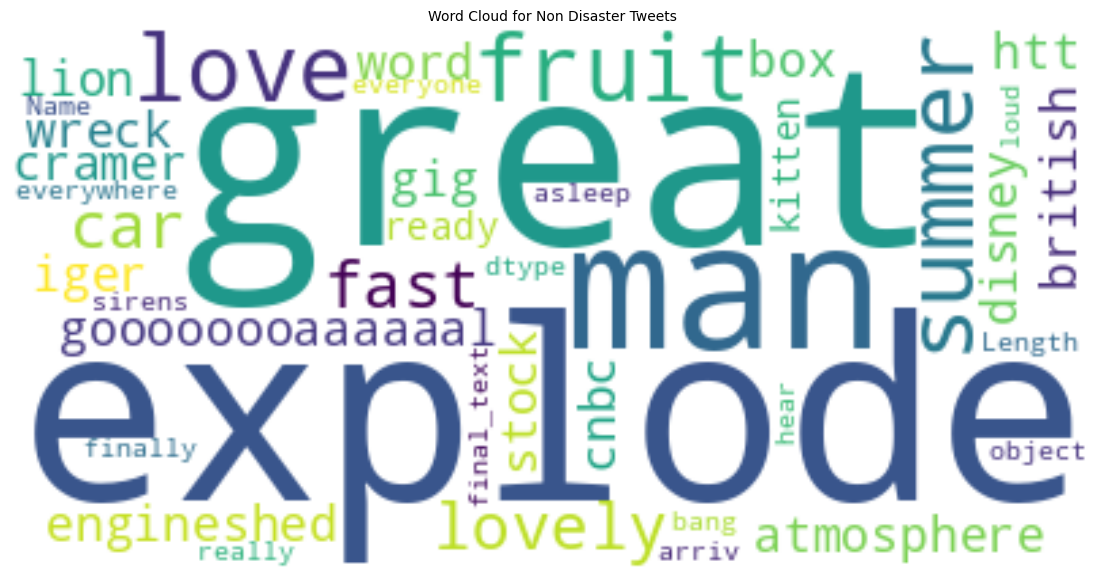

In [19]:
word_cloud_not_disaster = WordCloud(max_words = 500, stopwords = stop_words,background_color='white',collocations = True,
                                random_state=100).generate(str((train_df_not_disaster['final_text'])))

plt.figure(figsize=(14, 10))
plt.imshow(word_cloud_not_disaster, interpolation='bilinear')
plt.title('Word Cloud for Non Disaster Tweets', fontsize = 10)
plt.axis('off')
plt.show()

In [20]:
word_cloud_disaster.words_

{'wildfire': 1.0,
 'fire': 0.6666666666666666,
 'deeds': 0.3333333333333333,
 'reason': 0.3333333333333333,
 'earthquake': 0.3333333333333333,
 'may': 0.3333333333333333,
 'allah': 0.3333333333333333,
 'forgive': 0.3333333333333333,
 'us': 0.3333333333333333,
 'forest': 0.3333333333333333,
 'near': 0.3333333333333333,
 'la': 0.3333333333333333,
 'ronge': 0.3333333333333333,
 'sask': 0.3333333333333333,
 'canada': 0.3333333333333333,
 'residents': 0.3333333333333333,
 'ask': 0.3333333333333333,
 'shelter': 0.3333333333333333,
 'place': 0.3333333333333333,
 'notify': 0.3333333333333333,
 'officer': 0.3333333333333333,
 'eva': 0.3333333333333333,
 'people': 0.3333333333333333,
 'receive': 0.3333333333333333,
 'evacuation': 0.3333333333333333,
 'ord': 0.3333333333333333,
 'get': 0.3333333333333333,
 'send': 0.3333333333333333,
 'photo': 0.3333333333333333,
 'ruby': 0.3333333333333333,
 'alaska': 0.3333333333333333,
 'smoke': 0.3333333333333333,
 'pou': 0.3333333333333333,
 'two': 0.3333333

In [21]:
word_cloud_not_disaster.words_

{'great': 1.0,
 'explode': 1.0,
 'man': 0.5,
 'love': 0.5,
 'fruit': 0.5,
 'summer': 0.5,
 'lovely': 0.5,
 'car': 0.5,
 'fast': 0.5,
 'goooooooaaaaaal': 0.5,
 'engineshed': 0.5,
 'atmosphere': 0.5,
 'british': 0.5,
 'lion': 0.5,
 'gig': 0.5,
 'cramer': 0.5,
 'iger': 0.5,
 'word': 0.5,
 'wreck': 0.5,
 'disney': 0.5,
 'stock': 0.5,
 'cnbc': 0.5,
 'htt': 0.5,
 'box': 0.5,
 'ready': 0.5,
 'kitten': 0.5,
 'finally': 0.5,
 'arriv': 0.5,
 'sirens': 0.5,
 'everywhere': 0.5,
 'hear': 0.5,
 'really': 0.5,
 'loud': 0.5,
 'bang': 0.5,
 'everyone': 0.5,
 'asleep': 0.5,
 'Name': 0.5,
 'final_text': 0.5,
 'Length': 0.5,
 'dtype': 0.5,
 'object': 0.5}

Word Cloud helps to visualize the most frequently used words in our data.
The top 10 Most frequently used words in Disasters reviews are `wildfire`,`fire`,`deeds`,`reason`,`earthquake`,`may`,`allah`,`forgive`,`us`,`forest` while in Non Disaster reviews are `great`,`explode`,`man`,`love`,`fruit`,`summer`,`lovely`,`car`,`fast`,`goooooooaaaaaal`.

## Build a Shallow Neural Network
Now that we are done with the text preprocessing and text visualization, the next thing is to build our text classification model.

Let's start with a simple model. The network will consists of two main layers: a vectorizer and an embedding layer.



In [22]:
X = train_df['final_text']
y = train_df['target']

In [23]:
from sklearn.model_selection import train_test_split

# split the data into training (80%) and validation sets (20%)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 100)
print(F"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (6090,), X_val: (1523,), y_train: (6090,), y_val: (1523,)


In [24]:
max_token = 7500
output_sequence_length = 128
output_dim = 128

vectorizer_layer = TextVectorization(max_tokens = max_token, standardize = "lower_and_strip_punctuation", output_mode = "int",
                                    output_sequence_length = output_sequence_length)

vectorizer_layer.adapt(X_train)
embedding_layer = Embedding(input_dim = max_token, output_dim = output_dim, input_length = output_sequence_length)

model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(Dense(1, activation='sigmoid'))
model.summary()

opt = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, verbose = False)

train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Training set accuracy: {train_acc}")

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation set accuracy: {val_acc}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 128)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128, 1)              │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 960,129 (3.66 MB)

 Trainable params: 960,129 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5993 - loss: 0.6719
Training set accuracy: 0.5856142044067383
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5735 - loss: 0.6818
Validation set accuracy: 0.5826083421707153


We achieved a `58%` accuracy on the validation set. There is still lot of rooms for improvement in the model.

# Build a Multi-Layer Deep Text Classification Model

In [25]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(GlobalAveragePooling1D())

model.add(Dense(128, activation='relu', kernel_regularizer= L1(0.0005)))
model.add(Dropout(0.6))

model.add(Dense(64, activation='relu', kernel_regularizer= L1L2(0.0005)))

model.add(Dense(32, activation='relu', kernel_regularizer= L2(0.0005)))

model.add(Dense(16, activation='relu', kernel_regularizer= L2(0.0005)))

model.add(Dense(8, activation='relu', kernel_regularizer= L2(0.0005)))

model.add(Dense(1, activation='sigmoid'))
model.summary()

opt = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, verbose = False)

train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Training set accuracy: {train_acc}")

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation set accuracy: {val_acc}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 128)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 987,521 (3.77 MB)

 Trainable params: 987,521 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5851 - loss: 0.7046
Training set accuracy: 0.5699507594108582
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5622 - loss: 0.7106
Validation set accuracy: 0.571897566318512


## Build a Multilayer Bidirectional LSTM Model

In [26]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.6))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))

model.add(Dense(64, activation='elu', kernel_regularizer= L1L2(0.0005)))
model.add(Dense(16, activation='elu', kernel_regularizer= L1(0.0005)))

model.add(Dense(8, activation='elu', kernel_regularizer= L2(0.0005)))
model.add(Dense(4, activation='elu'))

model.add(Dense(1, activation='sigmoid'))
model.summary()

opt = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, verbose=False)

train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Training set accuracy: {train_acc}")

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation set accuracy: {val_acc}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 128)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,791,233 (6.83 MB)

 Trainable params: 1,791,233 (6.83 MB)

 Non-trainable params: 0 (0.00 B)

191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9568 - loss: 0.3520
Training set accuracy: 0.9558292031288147
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7896 - loss: 0.7642
Validation set accuracy: 0.7885751724243164
